<a href="https://colab.research.google.com/github/HiruniWijerathna/CropCare-Mini_Project/blob/Nilakshi/potato_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import zipfile
import numpy as np
import pathlib
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import sys

In [21]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d abdallahalidev/plantvillage-dataset # tomato, potato

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
plantvillage-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [22]:
current_path = '/content'

In [23]:
zip_ref = zipfile.ZipFile(os.path.join(current_path, 'plantvillage-dataset.zip'))
zip_ref.extractall()
zip_ref.close()

In [24]:
!rm /content/'plantvillage_dataset' -dr
!cp 'plantvillage dataset' plantvillage_dataset -r

rm: cannot remove '/content/plantvillage_dataset': No such file or directory


In [25]:
train_imgs_path = os.path.join(current_path, 'plantvillage_dataset', 'color')

In [26]:
!dir {train_imgs_path}

Apple___Apple_scab				     Pepper,_bell___healthy
Apple___Black_rot				     Potato___Early_blight
Apple___Cedar_apple_rust			     Potato___healthy
Apple___healthy					     Potato___Late_blight
Blueberry___healthy				     Raspberry___healthy
Cherry_(including_sour)___healthy		     Soybean___healthy
Cherry_(including_sour)___Powdery_mildew	     Squash___Powdery_mildew
Corn_(maize)___Cercospora_leaf_spot\ Gray_leaf_spot  Strawberry___healthy
Corn_(maize)___Common_rust_			     Strawberry___Leaf_scorch
Corn_(maize)___healthy				     Tomato___Bacterial_spot
Corn_(maize)___Northern_Leaf_Blight		     Tomato___Early_blight
Grape___Black_rot				     Tomato___healthy
Grape___Esca_(Black_Measles)			     Tomato___Late_blight
Grape___healthy					     Tomato___Leaf_Mold
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)	     Tomato___Septoria_leaf_spot
Orange___Haunglongbing_(Citrus_greening)	     Tomato___Spider_mites\ Two-spotted_spider_mite
Peach___Bacterial_spot				     Tomato___Target_Spot
Peach___healt

In [27]:
def balance_images_per_class(path, crop_name, max_num_imgs):
  data_dir = pathlib.Path(train_imgs_path)
  class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
  class_names = [class_name for class_name in class_names if crop_name in class_name]

  num_img_class = dict()
  for class_name in class_names:
    path_to_class = os.path.join(path, class_name)
    class_dir = pathlib.Path(path_to_class)

    image_paths = [item.name for item in class_dir.glob('*')]
    random.shuffle(image_paths)
    for i, image_path in enumerate(image_paths):
      if max_num_imgs <= i:
        os.remove(os.path.join(path_to_class, image_path))


def class_names_num_imgs_per_class(path, crop_name):
  data_dir = pathlib.Path(train_imgs_path)
  class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
  class_names = [class_name for class_name in class_names if crop_name in class_name]

  num_img_class = dict()
  for class_name in class_names:
    path_to_class = os.path.join(path, class_name)
    class_dir = pathlib.Path(path_to_class)

    image_paths = [item.name for item in class_dir.glob('*')]
    num_img_class[class_name] = len(image_paths)

  return num_img_class

In [28]:
crop_name = 'Potato'

In [29]:
class_names_num_imgs = class_names_num_imgs_per_class(train_imgs_path, crop_name)
min = min(class_names_num_imgs.values())
max = max(class_names_num_imgs.values())
print(min, max)

152 1000


In [30]:
balance_images_per_class(train_imgs_path, crop_name, min)

In [31]:
class_names_num_imgs = class_names_num_imgs_per_class(train_imgs_path, crop_name)
print(class_names_num_imgs)
class_names = class_names_num_imgs.keys()

{'Potato___Early_blight': 152, 'Potato___Late_blight': 152, 'Potato___healthy': 152}


In [32]:
def view_random_images(target_dir, target_class):

    target_folder = os.path.join(target_dir, target_class)

    random_image = random.sample(os.listdir(target_folder), 1)
    print(random_image)

    img = mpimg.imread(os.path.join(target_folder, random_image[0]))
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off')
    plt.show()

    print(f'image shape : {img.shape}')

['fdc691b0-2b15-4cb6-8f5d-c4e5654389e0___RS_Early.B 7935.JPG']


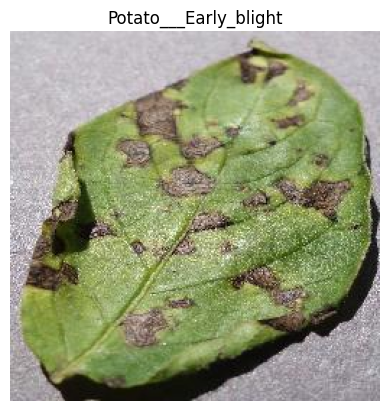

image shape : (256, 256, 3)
['baac20f4-7978-4258-8cd0-f3f8fe98bf83___RS_LB 4774.JPG']


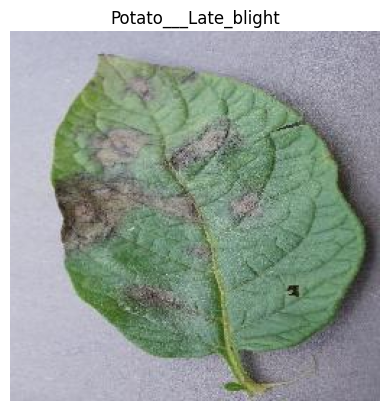

image shape : (256, 256, 3)
['e1b49d1b-165b-4f4e-8a30-735e62bc39c5___RS_HL 1839.JPG']


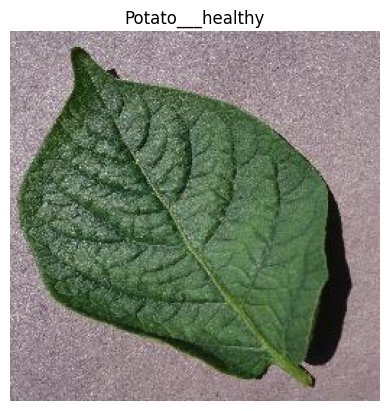

image shape : (256, 256, 3)


In [33]:
for class_name in class_names:
  view_random_images(train_imgs_path, class_name)

In [34]:
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True
        )

train_data_set = train_datagen.flow_from_directory(
        train_imgs_path,
        target_size=(224, 224),
        batch_size=32,
        shuffle=True,
        classes = class_names,
        class_mode='categorical')

Found 456 images belonging to 3 classes.


In [35]:
def create_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, activation="relu", input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPool2D(pool_size=5),
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=3),
    tf.keras.layers.Conv2D(filters=8, kernel_size=2, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(class_names), activation="softmax")
  ])

  model.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=["accuracy"])

  return model

In [37]:
cnn = create_model()

device_name = tf.test.gpu_device_name()
print('Found GPU at: {}'.format(device_name))

Found GPU at: 


In [38]:
with tf.device(''):
  history = cnn.fit(train_data_set, epochs=50)

Epoch 1/50
15/15 [==============================] - 27s 2s/step - loss: 1.0770 - accuracy: 0.4123
Epoch 2/50
15/15 [==============================] - 26s 2s/step - loss: 1.0647 - accuracy: 0.3750
Epoch 3/50
15/15 [==============================] - 23s 2s/step - loss: 1.0057 - accuracy: 0.5132
Epoch 4/50
15/15 [==============================] - 25s 2s/step - loss: 0.9592 - accuracy: 0.5417
Epoch 5/50
15/15 [==============================] - 25s 2s/step - loss: 0.9415 - accuracy: 0.5197
Epoch 6/50
15/15 [==============================] - 23s 1s/step - loss: 0.8431 - accuracy: 0.5987
Epoch 7/50
15/15 [==============================] - 26s 2s/step - loss: 0.7286 - accuracy: 0.6952
Epoch 8/50
15/15 [==============================] - 25s 2s/step - loss: 0.6671 - accuracy: 0.7039
Epoch 9/50
15/15 [==============================] - 23s 1s/step - loss: 0.6059 - accuracy: 0.7215
Epoch 10/50
15/15 [==============================] - 24s 2s/step - loss: 0.5701 - accuracy: 0.7588
Epoch 11/50
15/15 [

In [39]:
model_path = os.path.join(current_path, 'models', 'potato.h5')
cnn.save(model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


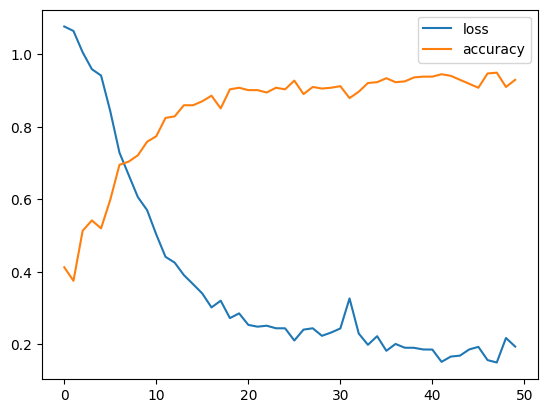

In [40]:
import pandas as pd
pd.DataFrame(history.history).plot();

In [41]:
model = create_model()
model.load_weights(model_path)

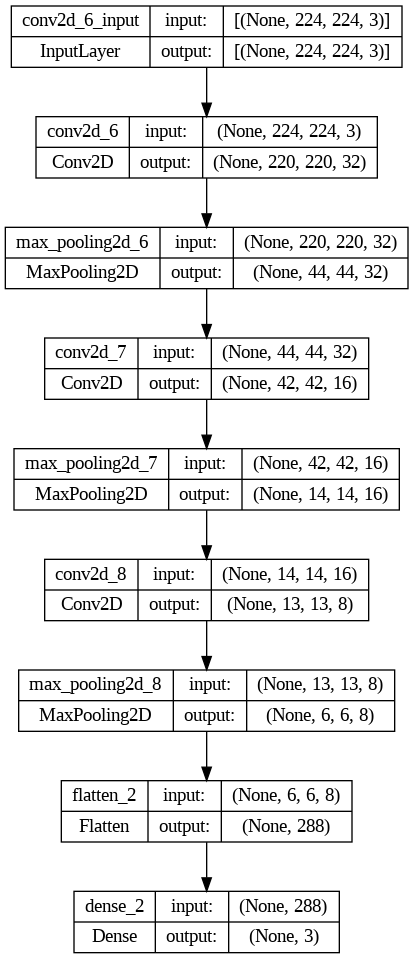

In [42]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [43]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 220, 220, 32)      2432      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 44, 44, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 42, 42, 16)        4624      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 13, 13, 8)         520       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 6, 6, 8)          

In [44]:
img_paths = train_data_set.filenames
num_images = len(img_paths)
i = 1
predictions = []
prediction_probs = []

for img_path in img_paths:

  full_path_to_img = os.path.join(train_imgs_path, img_path)
  img = tf.keras.utils.load_img(
      full_path_to_img, grayscale=False, color_mode='rgb', target_size=[224, 224],
      interpolation='nearest'
  )
  input_arr = tf.keras.preprocessing.image.img_to_array(img)
  input_arr = np.array([input_arr])  # Convert single image to a batch.
  input_arr = input_arr / 255
  predictions.append(np.argmax(model.predict(input_arr)))

  pres = (i*100)/num_images
  if i % 100 == 0:
    sys.stdout.write('\r' + f'{pres:.2f} % , {i}/{num_images}')
  i+=1

true_labels = train_data_set.labels

error_label_count = 0

for i in range(len(true_labels)):
  if true_labels[i] != predictions[i]:
    error_label_count+=1


test_accuracy = 100*(1-(error_label_count/len(true_labels)))
print()
print("Train accuracy: {:5.2f}%".format(test_accuracy))

1/1 [==============================] - 0s 35ms/step

Train accuracy: 95.18%


In [51]:
from sklearn.metrics import confusion_matrix
import itertools

def displayConfusionMatrix(y_true, y_pred, classes=None, text_size=8, figsize = (20, 10)):

    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    n_classes = cm.shape[0]

    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    ax.set(
        title='Confusion Matrix',
        xlabel='Predicted Labels',
        ylabel='True Labels',
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        yticklabels=labels
        )
    ax.set_xticklabels(labels, rotation=90)
    ax.xaxis.set_label_position('bottom')
    ax.xaxis.tick_bottom()

    ax.xaxis.label.set_size(text_size)
    ax.yaxis.label.set_size(text_size)
    ax.title.set_size(text_size)

    threshold = (cm.max() + cm.min()) / 2.0

    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)',
        horizontalalignment='center',
        color='white' if cm[i, j] > threshold else 'black',
        size=text_size)

In [52]:
short_class_names = []
for class_name in class_names:
  short_class_names.append(class_name[9:])

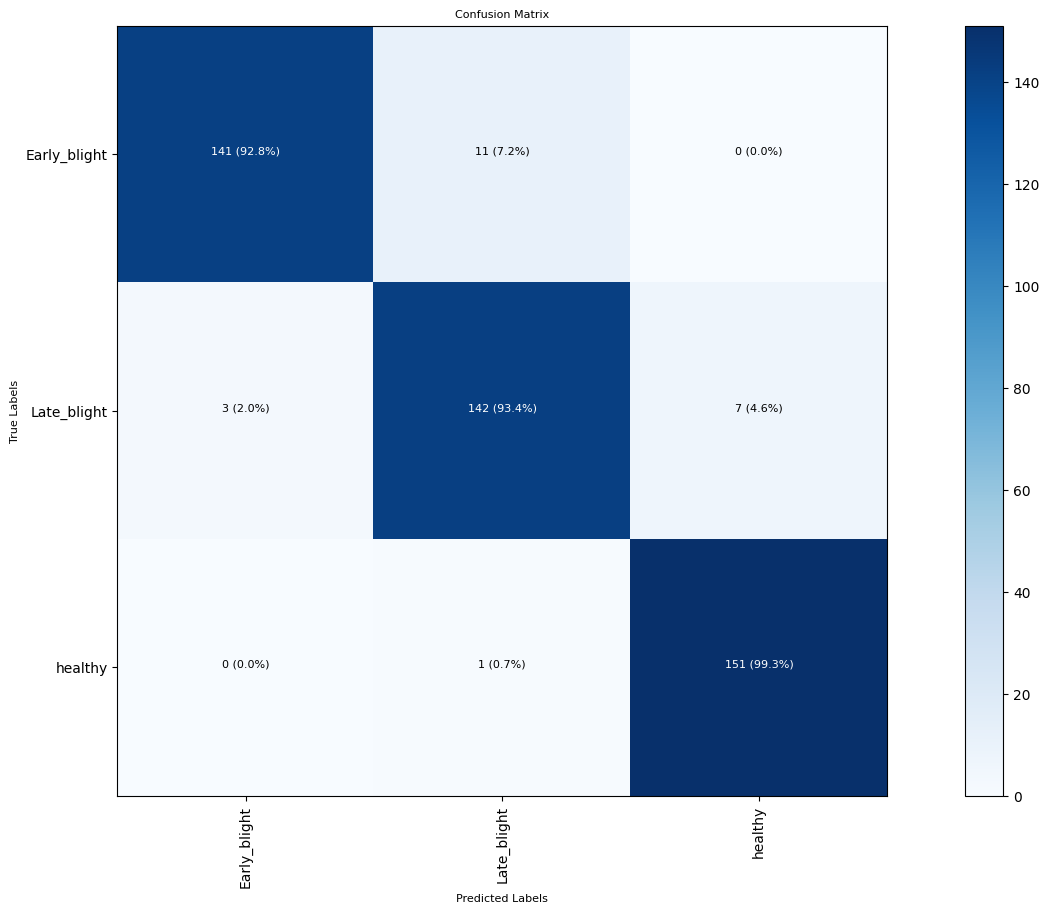

In [53]:
displayConfusionMatrix(train_data_set.labels, predictions, short_class_names)